In [1]:
!pip install torch torchvision torchtext pandas spacy scikit-learn torchsummary seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [14]:
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import KFold
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
# tell pytorch to use the gpu if available
if torch.cuda.is_available():    
      
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3080


In [16]:
# 定义基本参数
num_classes = 4  # AG News有四个类别
embedding_dim = 128
hidden_dim = 128
batch_size = 64
num_epochs = 3
k_folds = 3

In [17]:
# 读取数据集
train_df = pd.read_csv('train.csv')  # 请将此路径替换为实际文件路径
test_df = pd.read_csv('test.csv')    # 请将此路径替换为实际文件路径

In [18]:
train_df

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [19]:
test_df

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [20]:
# 构建词汇表，使用训练集的文本
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# 使用训练集的文本来构建词汇表
vocab = build_vocab_from_iterator(yield_tokens(train_df['Description']), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])
pad_idx = vocab['<pad>']

# 定义自定义数据集
class AGNewsDataset(Dataset):
    def __init__(self, df, vocab, tokenizer):
        self.texts = df['Description'].tolist()
        self.labels = df['Class Index'].tolist()
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx] - 1  # 标签从0开始
        tokens = self.tokenizer(text)
        token_ids = self.vocab(tokens)
        return torch.tensor(token_ids), label

# 定义collate_fn以处理可变长度的序列
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        lengths.append(len(_text))
        text_list.append(_text)
    labels = torch.tensor(label_list, dtype=torch.long)
    texts = pad_sequence(text_list, batch_first=True, padding_value=pad_idx)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return texts, labels, lengths

# 创建训练和测试数据集
train_dataset = AGNewsDataset(train_df, vocab, tokenizer)
test_dataset = AGNewsDataset(test_df, vocab, tokenizer)

In [21]:
# 定义LSTM模型
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=1, bidirectional=True):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        logits = self.fc(hidden)
        return logits

In [22]:
# 设置K折交叉验证
kfold = KFold(n_splits=k_folds, shuffle=True)

best_val_accuracy = 0.0
best_model_state = None

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold + 1}/{k_folds}')
    print('----------------------------')

    # 创建数据采样器和加载器
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler, collate_fn=collate_batch)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler, collate_fn=collate_batch)

    # 初始化模型、损失函数和优化器
    model = TextLSTM(len(vocab), embedding_dim, hidden_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        total_acc, total_count = 0, 0

        for texts, labels, lengths in train_loader:
            optimizer.zero_grad()
            texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

        print(f'Epoch {epoch + 1}, Training accuracy: {total_acc / total_count:.4f}')

    # 验证模型
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for texts, labels, lengths in val_loader:
            texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
            outputs = model(texts, lengths)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    val_accuracy = total_acc / total_count
    print(f'Validation accuracy: {val_accuracy:.4f}\n')

    # 保存验证准确率最高的模型
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()

Fold 1/3
----------------------------
Epoch 1, Training accuracy: 0.7834
Epoch 2, Training accuracy: 0.9026
Epoch 3, Training accuracy: 0.9300
Validation accuracy: 0.8954

Fold 2/3
----------------------------
Epoch 1, Training accuracy: 0.7815
Epoch 2, Training accuracy: 0.9025
Epoch 3, Training accuracy: 0.9301
Validation accuracy: 0.8971

Fold 3/3
----------------------------
Epoch 1, Training accuracy: 0.7866
Epoch 2, Training accuracy: 0.9024
Epoch 3, Training accuracy: 0.9322
Validation accuracy: 0.8994



In [23]:
# 使用整个训练集训练最终模型
final_model = TextLSTM(len(vocab), embedding_dim, hidden_dim, num_classes).to(device)
final_model.load_state_dict(best_model_state)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)

# 创建完整的训练数据加载器
full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# 再训练模型，使用整个训练集
for epoch in range(num_epochs):
    final_model.train()
    total_acc, total_count = 0, 0

    for texts, labels, lengths in full_train_loader:
        optimizer.zero_grad()
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
        outputs = final_model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

    print(f'Final Epoch {epoch + 1}, Training accuracy: {total_acc / total_count:.4f}')

Final Epoch 1, Training accuracy: 0.9324
Final Epoch 2, Training accuracy: 0.9506
Final Epoch 3, Training accuracy: 0.9649


Classification Report:
              precision    recall  f1-score   support

           0     0.9299    0.8932    0.9111      1900
           1     0.9693    0.9463    0.9577      1900
           2     0.8347    0.8847    0.8590      1900
           3     0.8688    0.8716    0.8702      1900

    accuracy                         0.8989      7600
   macro avg     0.9007    0.8989    0.8995      7600
weighted avg     0.9007    0.8989    0.8995      7600

Confusion Matrix:
[[1697   32  107   64]
 [  33 1798   46   23]
 [  50    6 1681  163]
 [  45   19  180 1656]]


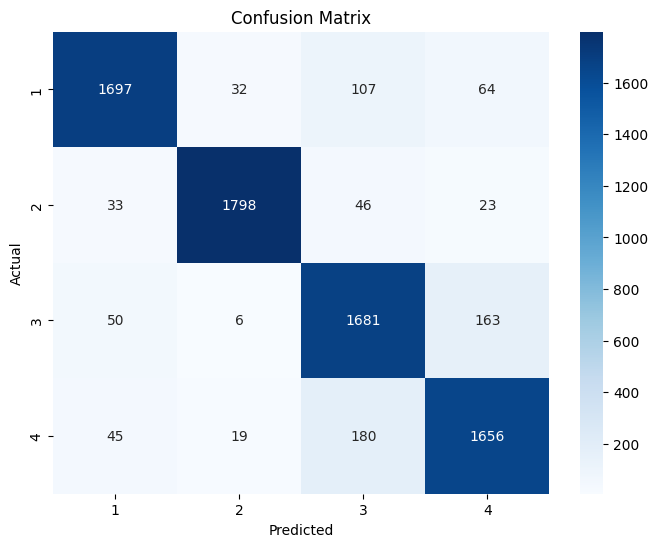

In [24]:
# 在测试集上评估模型
final_model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)
    for texts, labels, lengths in test_loader:
        texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)
        outputs = final_model(texts, lengths)
        preds = outputs.argmax(1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 生成分类报告
print("Classification Report:")
print(classification_report(test_labels, test_preds, digits=4))

# 生成混淆矩阵
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()